Next, we will assess whether there are differences in cell type abundances between the samples. We will use [scCODA](https://github.com/theislab/scCODA) for this purpose

In [3]:
import pickle

import pandas as pd
from scipy.stats import pearsonr

import sccoda
from sccoda.util import cell_composition_data as cc_dat
from sccoda.util import data_visualization as cc_viz
from sccoda.util import comp_ana as cc_mod

data_path = '/data3/hratch/STAT4_v2/'

In [4]:
# load the single cell metadata
md = pd.read_csv(data_path + 'processed/pbmc_integrated_metadata.csv', index_col = 0)[['orig.ident', 'Cell.Type']]
md.columns = ['Condition', 'Cell_Type']
md['Conditions'] = md.Condition.apply(lambda x: x.replace('.', '_'))

# drop neutrophils - https://mail.google.com/mail/u/0/#inbox/KtbxLxGkMGNvrmhGVSmCcqVmZQzQRWFFSV
md = md[md.Cell_Type != 'Neutrophils']

# create the cell counts dataframe
co = ['Naive CD4+ T cells', 'Effector CD4+ T cells', 'Memory CD4+ T cells', 'Regulatory CD4+ T cells', 
       'Naive CD8+ T cells', 'γδ-T cells', 'CD8+ NKT-like cells', 'Natural killer  cells', 
       'Naive B cells', 'Pre-B cells', 'Plasma B cells', 'Memory B cells',
 'Plasmacytoid Dendritic cells', 'Classical Monocytes', 'Non-classical monocytes', #'Neutrophils',
  'Erythroid-like and erythroid precursor cells', 'Platelets']

cell_counts = pd.DataFrame(data = {'Counts': md.groupby('Condition').value_counts()}).reset_index()
cell_counts = cell_counts.pivot(index = 'Condition', columns = 'Cell_Type')['Counts'].fillna(0)
cell_counts = cell_counts.apply(pd.to_numeric, errors='coerce', downcast='integer', axis = 0)
cell_counts = cell_counts[co]

# get the dispersion to decide on what the reference cell type should be
cell_freq = cell_counts.div(cell_counts.sum(axis = 1), axis = 0)
cell_disp = cell_freq.var(ddof = 0, axis = 0)/cell_freq.mean(axis = 0)
cell_disp = pd.DataFrame(data = {'Frequency_Dispersion': cell_disp})
cell_disp['Frequency_Mean'] = cell_freq.mean().loc[cell_disp.index]
cell_disp.sort_values(by = ['Frequency_Dispersion', 'Frequency_Mean'], inplace = True)

cell_counts.reset_index(inplace = True)
cell_counts.rename_axis(None, axis=1, inplace = True)

# convert to input of scCODA
cell_counts = cc_dat.from_pandas(cell_counts, covariate_columns=["Condition"])

/home/hratch/anaconda3/envs/STAT4_v2/lib/python3.10/site-packages/sccoda/util/cell_composition_data.py:294: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return ad.AnnData(X=count_data.values,


<AxesSubplot: title={'center': 'Condition'}, ylabel='Proportion'>

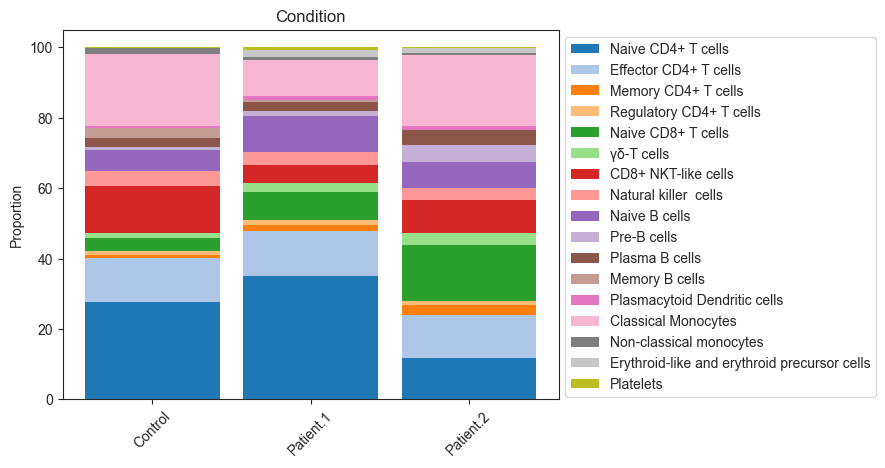

In [5]:
# to do: flip legend order

cc_viz.stacked_barplot(cell_counts, feature_name = 'Condition')

We need to select a reference cell type. We should first ensure that they are present in many samples (90% of samples here) (x-axis) and that they have low composition dispersion across these samples (y-axis). 

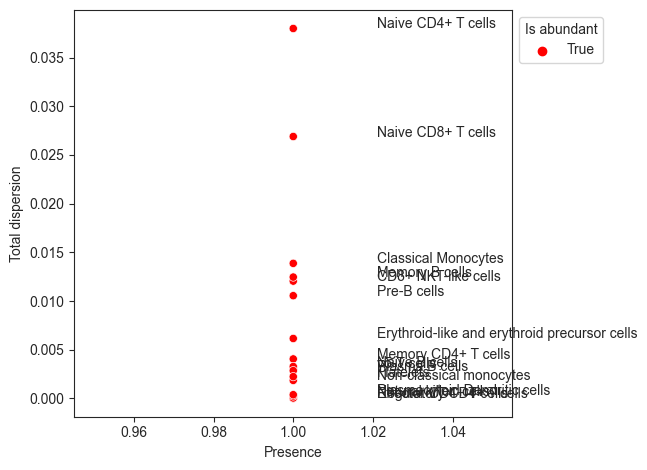

In [6]:
g = cc_viz.rel_abundance_dispersion_plot(
    data=cell_counts,
    abundant_threshold=0.9
)

The order of the cells above is:

In [7]:
cell_disp

,Frequency_Dispersion,Frequency_Mean
Cell_Type,,
Effector CD4+ T cells,0.000020,0.124077
Regulatory CD4+ T cells,0.000046,0.012332
Natural killer cells,0.000248,0.037863
Plasmacytoid Dendritic cells,0.000384,0.009576
Non-classical monocytes,0.001851,0.011036
Platelets,0.002240,0.002980
Plasma B cells,0.002853,0.030555
γδ-T cells,0.003103,0.025010
Naive B cells,0.003277,0.078742


Note that there is a positive correlation between Cell Type frequency dispersion and mean across samples:

In [8]:
pearsonr(cell_disp.Frequency_Dispersion, cell_disp.Frequency_Mean)

PearsonRResult(statistic=0.7251689926261293, pvalue=0.0009877593677842)

In [9]:
pbmc_mod_reg = cc_mod.CompositionalAnalysis(data = cell_counts, 
                                       reference_cell_type="Regulatory CD4+ T cells", # same as setting to automatic
                                       formula = "Condition")
pbmc_results_reg = pbmc_mod_reg.sample_hmc()
pbmc_results_reg.set_fdr(est_fdr=0.1)

2022-09-26 20:38:21.728593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-26 20:38:21.731239: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-26 20:38:21.731278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jabba): /proc/driver/nvidia/version does not exist
2022-09-26 20:38:26.145090: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa2a400e140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-26 20:38:26.145153: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
  0%|                                                 | 0/20000 [00:00<?, ?it/s]2022-09-26 20:38:26.477047: I tensorflow/compiler/mlir/te

MCMC sampling finished. (221.885 sec)
Acceptance rate: 57.3%


Since it is present in all samples and has the lowest dispersion, scCODA will choose Regulatory CD4+ T-cells as the reference cell type if using their automatic selection parameter. Since Effector CD4+ T-cells represent a much higher mean frequency as compared to many of the other cell types with low dispersion, it may be worth also testing this as the reference cell type. 

In [10]:
pbmc_mod_eff = cc_mod.CompositionalAnalysis(data = cell_counts, 
                                       reference_cell_type="Effector CD4+ T cells", # same as automatic
                                       formula = "Condition")
pbmc_results_eff = pbmc_mod_eff.sample_hmc()
pbmc_results_eff.set_fdr(est_fdr=0.1)

100%|█████████████████████████████████████| 20000/20000 [03:24<00:00, 97.74it/s]


MCMC sampling finished. (256.814 sec)
Acceptance rate: 53.6%


Since both reference cell types give the same "credible effects", i.e., identify the same cell types that are effected by the Condition covariate, we proceed with the default automatic refernece cell type of regulatory CD4+ T-cells.

In [11]:
pbmc_results_eff.credible_effects().equals(pbmc_results_reg.credible_effects())

True

In [16]:
pbmc_results = pbmc_results_reg

with open(data_path + 'processed/scCODA_model.pickle', 'wb') as handle:
    pickle.dump(pbmc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

At an FDR of 0.1, only Naive CD4+ T-cells in Patient 2 vs Control are significantly differentially abundant with an LFC of -1.03:

In [13]:
pbmc_results.set_fdr(est_fdr=0.1)
pbmc_results.effect_df[pbmc_results.effect_df['Final Parameter'] != 0]

Final Parameter  HDI 3%  HDI 97%  \
Covariate              Cell Type                                              
Condition[T.Patient.2] Naive CD4+ T cells        -0.860568  -1.476   -0.227   
                       Naive CD8+ T cells         0.805084  -0.011    1.533   

                                              SD  Inclusion probability  \
Covariate              Cell Type                                          
Condition[T.Patient.2] Naive CD4+ T cells  0.340               0.984400   
                       Naive CD8+ T cells  0.488               0.836867   

                                           Expected Sample  log2-fold change  
Covariate              Cell Type                                              
Condition[T.Patient.2] Naive CD4+ T cells       643.369401         -1.104883  
                       Naive CD8+ T cells       715.778813          1.298145

Here is displayed all the estimated LFC's regardless of significant changes. Interestingly, only Patient 2 vs control shows non-zero LFC (Patient 1 vs Control indicates no change, even disregarding significance):

In [14]:
pbmc_results.effect_df['log2-fold change']

Covariate               Cell Type                                   
Condition[T.Patient.1]  Naive CD4+ T cells                              0.000000
                        Effector CD4+ T cells                           0.000000
                        Memory CD4+ T cells                             0.000000
                        Regulatory CD4+ T cells                         0.000000
                        Naive CD8+ T cells                              0.000000
                        γδ-T cells                                      0.000000
                        CD8+ NKT-like cells                             0.000000
                        Natural killer  cells                           0.000000
                        Naive B cells                                   0.000000
                        Pre-B cells                                     0.000000
                        Plasma B cells                                  0.000000
                        Memory B cells  

The significantly changed cell types change somewhat at an FDR of 0.2:

In [15]:
pbmc_results.set_fdr(est_fdr=0.2)
pbmc_results.effect_df[pbmc_results.effect_df['Final Parameter'] != 0]

Final Parameter  HDI 3%  HDI 97%  \
Covariate              Cell Type                                               
Condition[T.Patient.1] CD8+ NKT-like cells        -0.508736  -1.199    0.183   
                       Classical Monocytes        -0.507792  -1.106    0.061   
Condition[T.Patient.2] Naive CD4+ T cells         -0.860568  -1.476   -0.227   
                       Naive CD8+ T cells          0.805084  -0.011    1.533   
                       Memory B cells             -0.802238  -2.246    0.421   

                                               SD  Inclusion probability  \
Covariate              Cell Type                                           
Condition[T.Patient.1] CD8+ NKT-like cells  0.411               0.762200   
                       Classical Monocytes  0.364               0.770133   
Condition[T.Patient.2] Naive CD4+ T cells   0.340               0.984400   
                       Naive CD8+ T cells   0.488               0.836867   
                       Memory B cells       0.722               0.700400   

                                            Expected Sample  log2-fold change  
Covariate              Cell Type                                               
Condition[T.Patient.1] CD8+ NKT-like cells       327.490810         -0.564247  
                       Classical Monocytes       587.222624         -0.562885  
Condition[T.Patient.2] Naive CD4+ T cells        647.293261         -1.096111  
                       Naive CD8+ T cells        720.144293          1.306917  
                       Memory B cells             24.049876         -1.011958